# CS146 Final Project: Modeling and forecasting atmospheric CO₂ from 1958 into the future

## Data Preprocessing

In [1]:
import pandas as pd

In [2]:
data_co2 = pd.read_csv('weekly_in_situ_co2_mlo.csv', skiprows=44, names=['date', 'co2 ppm'])
data_co2.head()

,date,co2 ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


#### Converting dates

Let's convert dates so that they can be plotted as x-axis values, starting from 0.

In [3]:
data_co2['date']=pd.to_datetime(data_co2['date'])
start = data_co2['date'][0]
data_co2['datetime'] = data_co2['date'] - start
data_co2['date_num'] = data_co2['datetime'].dt.days

In [4]:
data_co2.head()

,date,co2 ppm,datetime,date_num
0,1958-03-29,316.19,0 days,0
1,1958-04-05,317.31,7 days,7
2,1958-04-12,317.69,14 days,14
3,1958-04-19,317.58,21 days,21
4,1958-04-26,316.48,28 days,28


In [5]:
data_co2.tail()

,date,co2 ppm,datetime,date_num
3237,2021-08-28,412.68,23163 days,23163
3238,2021-09-04,412.58,23170 days,23170
3239,2021-09-11,413.15,23177 days,23177
3240,2021-09-18,413.09,23184 days,23184
3241,2021-09-25,413.05,23191 days,23191


## Plotting data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

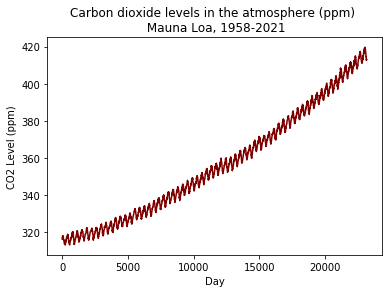

In [7]:
plt.plot(data_co2['date_num'], data_co2.iloc[:,1], color='maroon')
plt.ylabel('CO2 Level (ppm)', size=10)
plt.xlabel('Day', size=10)
plt.title("Carbon dioxide levels in the atmosphere (ppm) \n Mauna Loa, 1958-2021")
plt.show()

#### Using a function from class sessions to plot autocorrelation.

In [8]:
# plotting sample autocorrelation for every parameter
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

In [9]:
# displaying the autocorrelation plots
def acf_plots(posterior_samples, parameters):
    plt.figure(figsize=(15, 17))
    for x in range(len(parameters)):
        plt.subplot(4,3,x + 1)
        plot_acf(posterior_samples[parameters[x]])
        plt.title(f'Autocorrelation of {parameters[x]} samples')
    plt.show()

In [10]:
# plotting pair plot of the posteriors over all parameters
def pair_plots(posterior_samples, parameters):
    df = pd.DataFrame(
        data=np.transpose([posterior_samples[x] for x in parameters]),
        columns=parameters)
    sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

In [11]:
import pystan
import numpy as np
import scipy.stats as sts

## Linear Model

In [12]:
# input data
stan_data = {'N': len(data_co2['date_num']), 
            'co2': data_co2['co2 ppm'],
            'day': data_co2['date_num']}

In [16]:
# create the stan model

stan_code_linear_model = """

data {
    // model data
    int<lower=0> N;        //size of the data observations
    real<lower=0> co2[N];  //an observation of CO2 level
    real<lower=0> day[N];  // day of observation collection
}

parameters {
    // model parameters
    real<lower=0> c0;   // intercept parameter
    real<lower=0> c1;   // slope value parameter
    real<lower=0> c2; // seasonal variation parameter (multiplicator)
    real<lower=0, upper=1> c3;  // day variation parameter (added to annual number of days)    
    real<lower=0> sigma;        // noise parameter         
}


model {
    //priors 
    c0 ~ normal(300, 15); // prior based on the values of CO2 level at the start
    c1 ~ cauchy(0, 1); // slope (time) parameter prior
    c2 ~ cauchy(0, 1); // slope (seasonal variation) parameter prior
    c3 ~ cauchy(0, 1); // day (seasonal variation) parameter prior
    sigma ~ cauchy(0, 1); // prior for standard deviation^2 (variance)

    //likelihood
    for (observation in 1:N) {
      co2[observation] ~ normal(c0+c1*day[observation]+c2*cos(2*pi()*day[observation]/(365.25+c3)), sigma);
    }

}
"""

In [17]:
# make the model
stan_model_linear = pystan.StanModel(model_code=stan_code_linear_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ffd6c1b952a60a4150664b4196a35a9 NOW.


In [18]:
# fitting stan model to the data. 
# generating samples from the posterior over all parameters
stan_results_linear_model = stan_model_linear.sampling(data=stan_data)
print(stan_results_linear_model)

Inference for Stan model: anon_model_8ffd6c1b952a60a4150664b4196a35a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    305.45  2.1e-3   0.14 305.17 305.36 305.45 305.55 305.74   4708    1.0
c1    4.4e-3  1.6e-7 1.1e-5 4.4e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   4708    1.0
c2      2.83  2.2e-3    0.1   2.63   2.76   2.83   2.89   3.03   2073    1.0
c3      0.56  1.2e-3   0.06   0.45   0.52   0.56    0.6   0.67   2107    1.0
sigma   4.11  1.1e-3   0.05   4.01   4.07   4.11   4.14   4.21   2326    1.0
lp__   -6205    0.04    1.6  -6209  -6206  -6205  -6204  -6203   1352    1.0

Samples were drawn using NUTS at Wed Dec 15 22:28:37 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [19]:
# extracting the generated samples from the Stan model
samples_linear_model = stan_results_linear_model.extract()

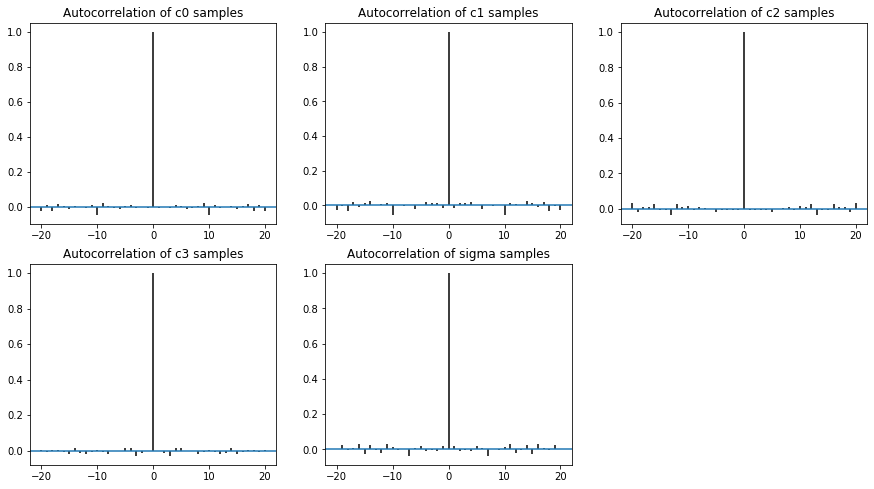

In [20]:
# putting all parameters in a list
parameter_linear_model = ['c0', 'c1', 'c2','c3','sigma']
# creating autocorrelation plots
acf_plots(samples_linear_model, parameter_linear_model)

/Users/andriykashyrskyy/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


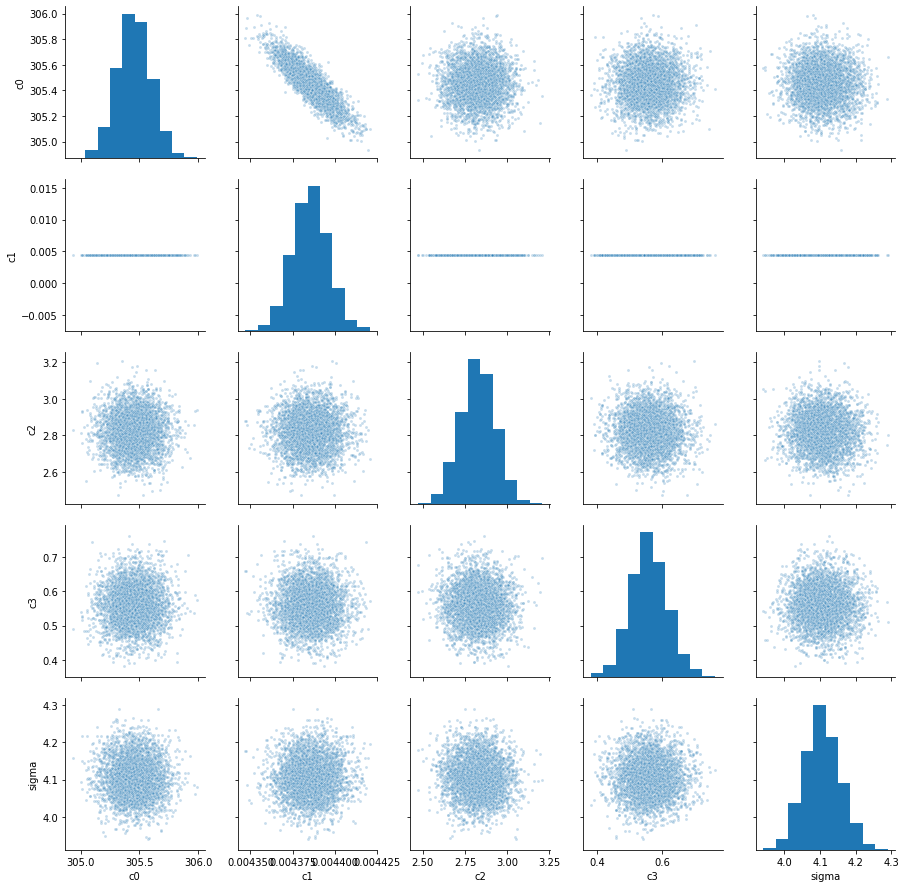

In [21]:
# creating pair plots
pair_plots(samples_linear_model, parameter_linear_model)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


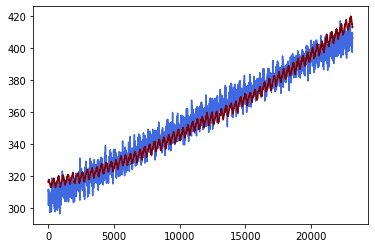

In [22]:
linear_model_co2 = np.array(sts.norm.rvs(np.mean(samples_linear_model['c0'])+ np.mean(samples_linear_model['c1'])*data_co2.iloc[:,3]+np.mean(samples_linear_model['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.mean(samples_linear_model['c3'])), np.mean(samples_linear_model['sigma'])))
plt.plot(data_co2.iloc[:,3], linear_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.show()


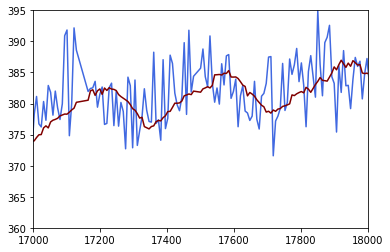

In [23]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], linear_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([17000, 18000, 360, 395])
plt.show()

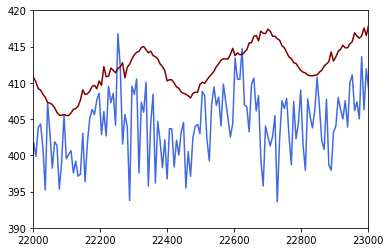

In [24]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], linear_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([22000, 23000, 390, 420])
plt.show()

## Quadratic Model

In [471]:
#Build the stan model
stan_code_quadratic_model = """

data {
    // model data
    int<lower=0> N;        //size of the data observations
    real<lower=0> co2[N];  //an observation of CO2 level
    real<lower=0> day[N];  // day of observation collection
}

parameters {
    // model parameters
    real<lower=0> c0;   // intercept parameter
    real<lower=0> c1;   // slope value parameter
    real<lower=0> c2; // seasonal variation parameter (multiplicator)
    real<lower=0, upper=1> c3;  // day variation parameter (added to annual number of days)    
    real<lower=0> sigma;        // noise parameter         
}


model {
    //priors 
    c0 ~ normal(300, 15); // prior based on the values of CO2 level at the start
    c1 ~ cauchy(0, 1); // slope (time) parameter prior
    c2 ~ cauchy(0, 1); // slope (seasonal variation) parameter prior
    c3 ~ cauchy(0, 1); // day (seasonal variation) parameter prior
    sigma ~ cauchy(0, 1); // prior for standard deviation^2 (variance)

    //likelihood
    for (observation in 1:N) {
      co2[observation] ~ normal(c0+c1*(day[observation]^2)+c2*cos(2*pi()*day[observation]/(365.25+c3)), sigma);
    }

}
"""

In [472]:
# compile the model
stan_model_quadratic = pystan.StanModel(model_code=stan_code_quadratic_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd80209179801134b066625c0725c203 NOW.


In [473]:
# fitting stan model to the data
# this will generate samples from the posterior over all parameters of the model.
stan_results_quadratic = stan_model_quadratic.sampling(data=stan_data)
print(stan_results_quadratic)

Inference for Stan model: anon_model_bd80209179801134b066625c0725c203.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    323.86  1.4e-3   0.09 323.68  323.8 323.86 323.92 324.04   4153    1.0
c1    1.8e-7 5.8e-123.9e-10 1.8e-7 1.8e-7 1.8e-7 1.8e-7 1.8e-7   4535    1.0
c2      2.77  1.9e-3   0.09   2.59    2.7   2.77   2.83   2.94   2206    1.0
c3       0.5  1.1e-3   0.05    0.4   0.47    0.5   0.54    0.6   2158    1.0
sigma   3.54  8.8e-4   0.04   3.46   3.51   3.54   3.57   3.63   2457    1.0
lp__   -5733    0.04   1.59  -5738  -5734  -5733  -5732  -5731   1483    1.0

Samples were drawn using NUTS at Wed Dec 15 20:14:19 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [474]:
# Extract the generated samples from the stan model
samples_quadratic_model = stan_results_quadratic.extract()

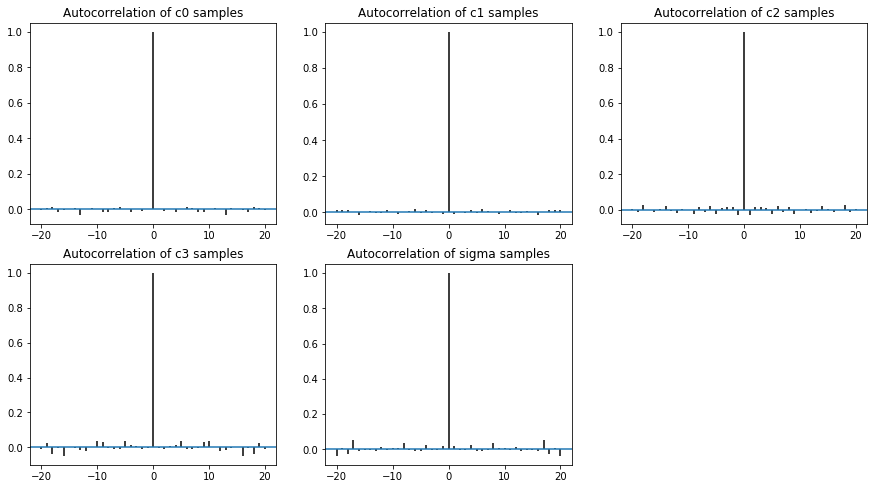

In [475]:
#autocorrelation plots
quadratic_parameters = ['c0', 'c1', 'c2', 'c3', 'sigma']
acf_plots(samples_quadratic_model, quadratic_parameters)

/Users/andriykashyrskyy/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


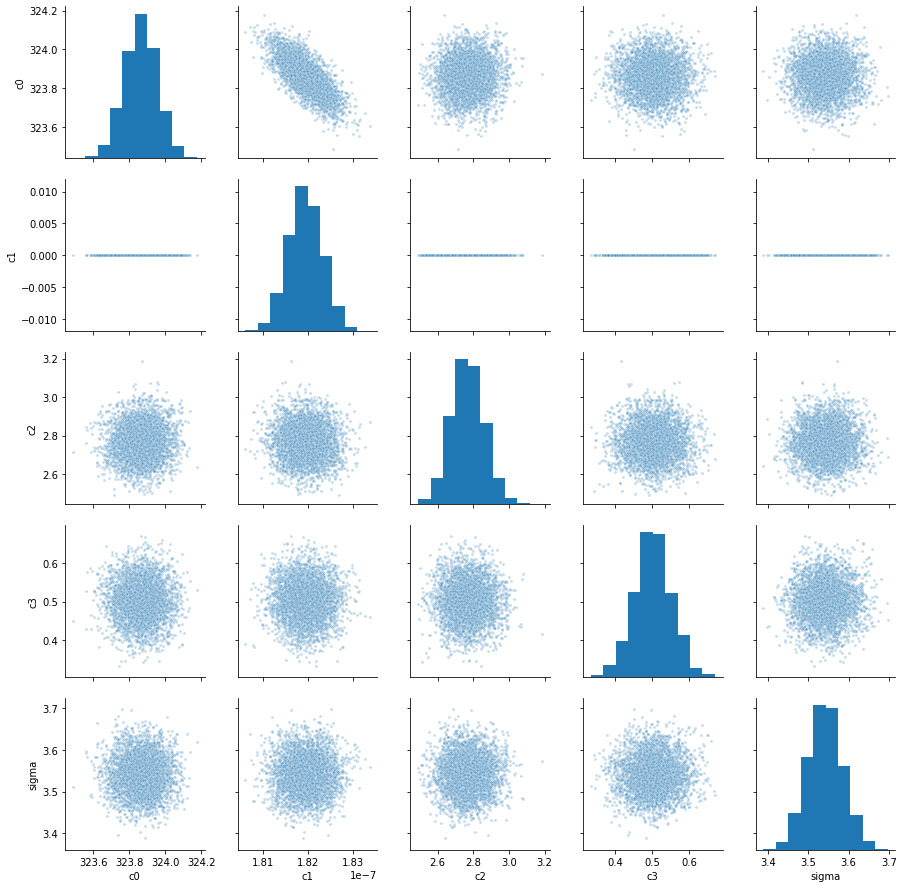

In [476]:
#pair plots
pair_plots(quadratic_samples, quadratic_parameters)

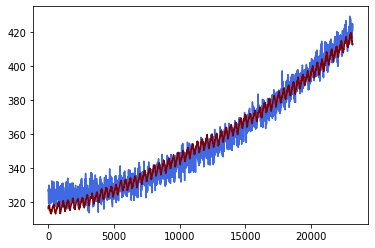

In [477]:
quadratic_model_co2 = np.array(sts.norm.rvs(np.mean(samples_quadratic_model['c0'])+ np.mean(samples_quadratic_model['c1'])*(data_co2.iloc[:,3]**2)+np.mean(samples_quadratic_model['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.mean(samples_quadratic_model['c3'])), np.mean(samples_quadratic_model['sigma'])))
plt.plot(data_co2.iloc[:,3], quadratic_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.show()

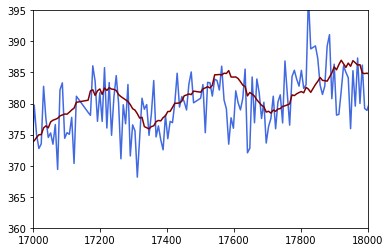

In [478]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], quadratic_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([17000, 18000, 360, 395])
plt.show()

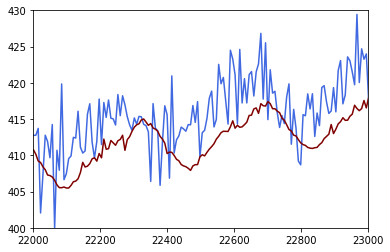

In [479]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], quadratic_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([22000, 23000, 400, 430])
plt.show()

## Exponential Model

In [12]:
# Create the stan model
stan_code_exponential_model = """

data {
    // model data
    int<lower=0> N;        //size of the data observations
    real<lower=0> co2[N];  //an observation of CO2 level
    real<lower=0> day[N];  // day of observation collection
}

parameters {
    // model parameters
    real<lower=0> c0;   // intercept parameter
    real<lower=0> c1;   // slope value parameter
    real<lower=0, upper=10> c2; // seasonal variation parameter (multiplicator)
    real<lower=0, upper=1> c3;  // day variation parameter (added to annual number of days)    
    real<lower=0> sigma;        // noise parameter         
}


model {
    //priors 
    c0 ~ normal(300, 15); // prior based on the values of CO2 level at the start
    c1 ~ cauchy(0, 1); // slope (time) parameter prior
    c2 ~ cauchy(0, 1); // slope (seasonal variation) parameter prior
    c3 ~ cauchy(0, 1); // day (seasonal variation) parameter prior
    sigma ~ cauchy(0, 1); // prior for standard deviation^2 (variance)

    //likelihood
    for (observation in 1:N) {
      co2[observation] ~ normal(c0+c1*(day[observation]^1.5)+c2*cos(2*pi()*day[observation]/(365.25+c3)), sigma);
    }

}
"""

In [13]:
#compile the model
stan_model_exponential= pystan.StanModel(model_code=stan_code_exponential_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e7a81df33b70a64f7890cd4d967066d NOW.


In [14]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results_exponential = stan_model_exponential.sampling(data=stan_data)
print(stan_results_exponential)

NameError: name 'stan_data' is not defined

In [ ]:
# Extract the generated samples from the stan model
samples_exponential = stan_results_exponential.extract()

In [ ]:
parameters_exponential = ['c0', 'c1', 'c2', 'c3', 'sigma']
acf_plots(samples_exponential, parameters_exponential)

In [ ]:
pair_plots(samples_exponential, parameters_exponential)

In [ ]:
exponential_model_co2 = np.array(sts.norm.rvs(np.mean(samples_exponential['c0'])+ np.mean(samples_exponential['c1'])*(data_co2.iloc[:,3]**1.5)+np.mean(samples_exponential['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.mean(samples_exponential['c3'])), np.mean(samples_exponential['sigma'])))
plt.plot(data_co2.iloc[:,3], exponential_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.show()

In [ ]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], exponential_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([17000, 18000, 360, 395])
plt.show()

In [ ]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], exponential_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([22000, 23000, 400, 430])
plt.show()

## Using test statistics for assessing the model

In [490]:
def test_statistic(data, stat_name):
    statistics = {'mean': np.mean,
                  'std': np.std,
                  'minimum': np.min,
                  'maximum': np.max}
    
    return statistics[stat_name](data)

### Linear Model

In [491]:
linear_data_replicated = []

mean_linear = []
std_linear = []
min_linear = []
max_linear = []

for i in range(1500):
    linear_data_replicated.append(np.array(sts.norm.rvs(np.random.choice(samples_linear_model['c0'])+ np.random.choice(samples_linear_model['c1'])*data_co2.iloc[:,3]+np.random.choice(samples_linear_model['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.random.choice(samples_linear_model['c3'])), np.random.choice(samples_linear_model['sigma']))))
    mean_linear.append(test_statistic(linear_data_replicated[-1], 'mean'))
    std_linear.append(test_statistic(linear_data_replicated[-1], 'std'))
    min_linear.append(test_statistic(linear_data_replicated[-1], 'minimum'))
    max_linear.append(test_statistic(linear_data_replicated[-1], 'maximum'))


#### Plotting test statistics for Linear Model

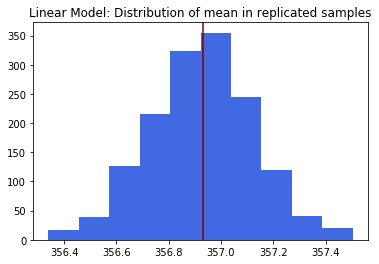

P-value: 0.503


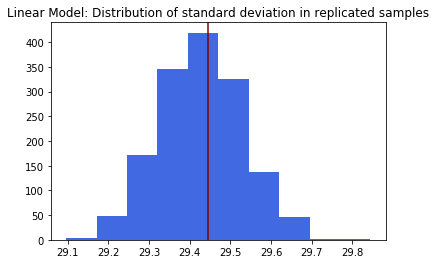

P-value: 0.439


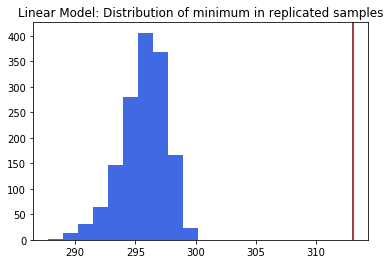

P-value: 0.0


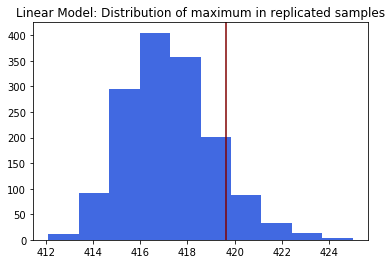

P-value: 0.108


In [492]:
# mean
plt.hist(mean_linear, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'mean'), color="maroon")
plt.title('Linear Model: Distribution of mean in replicated samples')
plt.show()

p_value = sum([1 for i in mean_linear if i > test_statistic(list(data_co2.iloc[:,1]), 'mean')])/1500
print("P-value:", round(p_value, 3))

# standard deviation
plt.hist(std_linear, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'std'), color="maroon")
plt.title('Linear Model: Distribution of standard deviation in replicated samples')
plt.show()

p_value = sum([1 for i in std_linear if i > test_statistic(list(data_co2.iloc[:,1]), 'std')])/1500
print("P-value:", round(p_value, 3))

# minimum
plt.hist(min_linear, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'minimum'), color="maroon")
plt.title('Linear Model: Distribution of minimum in replicated samples')
plt.show()

p_value = sum([1 for i in min_linear if i > test_statistic(list(data_co2.iloc[:,1]), 'minimum')])/1500
print("P-value:", round(p_value, 3))

# maximum
plt.hist(max_linear, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'maximum'), color="maroon")
plt.title('Linear Model: Distribution of maximum in replicated samples')
plt.show()

p_value = sum([1 for i in max_linear if i > test_statistic(list(data_co2.iloc[:,1]), 'maximum')])/1500
print("P-value:", round(p_value, 3))

### Quadratic model

In [493]:
quadratic_data_replicated = []

mean_quadratic = []
std_quadratic = []
min_quadratic = []
max_quadratic = []

for i in range(1500):
    quadratic_data_replicated.append(np.array(sts.norm.rvs(np.random.choice(samples_quadratic_model['c0'])+ np.random.choice(samples_quadratic_model['c1'])*(data_co2.iloc[:,3]**2)+np.random.choice(samples_quadratic_model['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.random.choice(samples_quadratic_model['c3'])), np.random.choice(samples_quadratic_model['sigma']))))
    mean_quadratic.append(test_statistic(quadratic_data_replicated[-1], 'mean'))
    std_quadratic.append(test_statistic(quadratic_data_replicated[-1], 'std'))
    min_quadratic.append(test_statistic(quadratic_data_replicated[-1], 'minimum'))
    max_quadratic.append(test_statistic(quadratic_data_replicated[-1], 'maximum'))

#### Plotting test statistics for Quadratic model

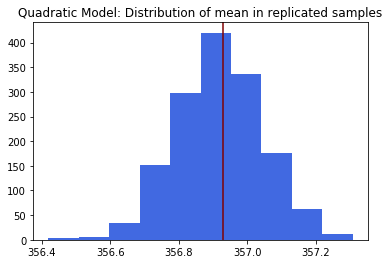

P-value: 0.459


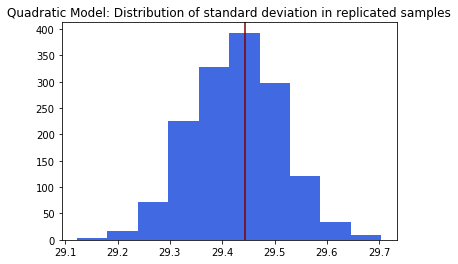

P-value: 0.43


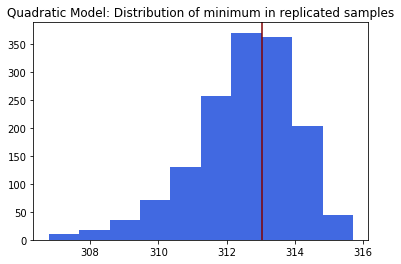

P-value: 0.403


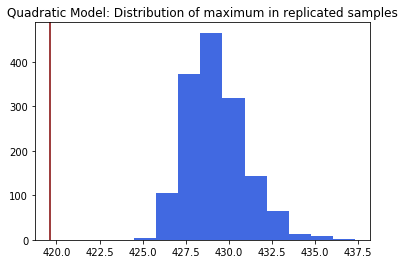

P-value: 1.0


In [494]:
# mean
plt.hist(mean_quadratic, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'mean'), color="maroon")
plt.title('Quadratic Model: Distribution of mean in replicated samples')
plt.show()
p_value = sum([1 for i in mean_quadratic if i > test_statistic(list(data_co2.iloc[:,1]), 'mean')])/1500
print("P-value:", round(p_value, 3))

# standard deviation
plt.hist(std_quadratic, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'std'), color="maroon")
plt.title('Quadratic Model: Distribution of standard deviation in replicated samples')
plt.show()
p_value = sum([1 for i in std_quadratic if i > test_statistic(list(data_co2.iloc[:,1]), 'std')])/1500
print("P-value:", round(p_value, 3))

# minimum
plt.hist(min_quadratic, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'minimum'), color="maroon")
plt.title('Quadratic Model: Distribution of minimum in replicated samples')
plt.show()
p_value = sum([1 for i in min_quadratic if i > test_statistic(list(data_co2.iloc[:,1]), 'minimum')])/1500
print("P-value:", round(p_value, 3))

# maximum
plt.hist(max_quadratic, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'maximum'), color="maroon")
plt.title('Quadratic Model: Distribution of maximum in replicated samples')
plt.show()
p_value = sum([1 for i in max_quadratic if i > test_statistic(list(data_co2.iloc[:,1]), 'maximum')])/1500
print("P-value:", round(p_value, 3))


### Exponential model

In [495]:
exponential_data_replicated = []

mean_exponential = []
std_exponential = []
min_exponential = []
max_exponential = []

for i in range(1500):
    exponential_data_replicated.append(np.array(sts.norm.rvs(np.random.choice(samples_exponential['c0'])+ np.random.choice(samples_exponential['c1'])*(data_co2.iloc[:,3]**1.5)+np.random.choice(samples_exponential['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.random.choice(samples_exponential['c3'])), np.random.choice(samples_exponential['sigma']))))
    mean_exponential.append(test_statistic(exponential_data_replicated[-1], 'mean'))
    std_exponential.append(test_statistic(exponential_data_replicated[-1], 'std'))
    min_exponential.append(test_statistic(exponential_data_replicated[-1], 'minimum'))
    max_exponential.append(test_statistic(exponential_data_replicated[-1], 'maximum'))

#### Plotting test statistics for Exponential model

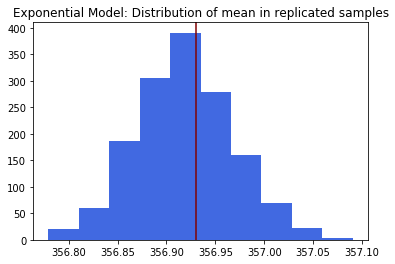

P-value: 0.404


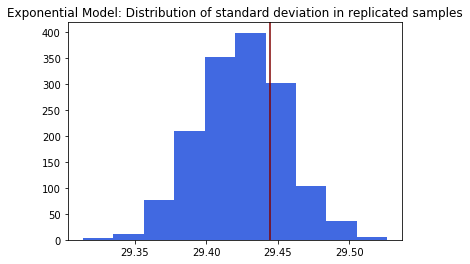

P-value: 0.261


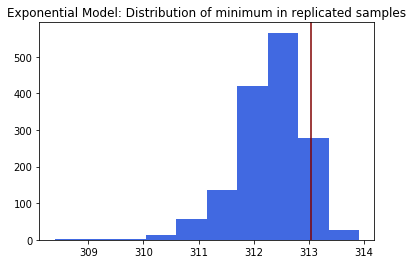

P-value: 0.093


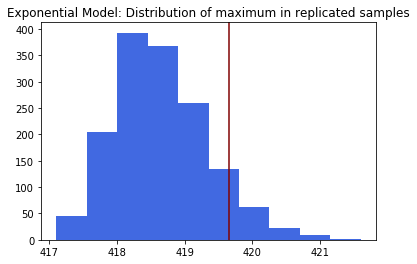

P-value: 0.094


In [496]:
# mean
plt.hist(mean_exponential, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'mean'), color="maroon")
plt.title('Exponential Model: Distribution of mean in replicated samples')
plt.show()
p_value = sum([1 for i in mean_exponential if i > test_statistic(list(data_co2.iloc[:,1]), 'mean')])/1500
print("P-value:", round(p_value, 3))

# standard deviation
plt.hist(std_exponential, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'std'), color="maroon")
plt.title('Exponential Model: Distribution of standard deviation in replicated samples')
plt.show()
p_value = sum([1 for i in std_exponential if i > test_statistic(list(data_co2.iloc[:,1]), 'std')])/1500
print("P-value:", round(p_value, 3))

# minimum
plt.hist(min_exponential, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'minimum'), color="maroon")
plt.title('Exponential Model: Distribution of minimum in replicated samples')
plt.show()
p_value = sum([1 for i in min_exponential if i > test_statistic(list(data_co2.iloc[:,1]), 'minimum')])/1500
print("P-value:", round(p_value, 3))

# maximum
plt.hist(max_exponential, color = "royalblue")
plt.axvline(test_statistic(list(data_co2.iloc[:,1]), 'maximum'), color="maroon")
plt.title('Exponential Model: Distribution of maximum in replicated samples')
plt.show()
p_value = sum([1 for i in max_exponential if i > test_statistic(list(data_co2.iloc[:,1]), 'maximum')])/1500
print("P-value:", round(p_value, 3))

## Predicting the CO2 levels in the future

In [497]:
N_future = int(39*365.25) + 23191
N_future_range = np.array(range(23191, N_future, 7))

def exponential_model_pred(posterior_samples, day_range, func, args=0):
    return np.array(sts.norm.rvs(func(posterior_samples['c0'], args) + func(posterior_samples['c1'], args)*(N_future_range**1.5)+ func(posterior_samples['c2'], args)*np.cos((2*np.pi*N_future_range)/365.25 + func(posterior_samples['c3'], args)), func(posterior_samples['sigma'], args)))

exponential_predicted = exponential_model_pred(samples_exponential, N_future_range, np.mean)


In [498]:
lower_ci = exponential_model_pred(samples_exponential, N_future_range, np.percentile, 2.5)
upper_ci = exponential_model_pred(samples_exponential, N_future_range, np.percentile, 97.5)

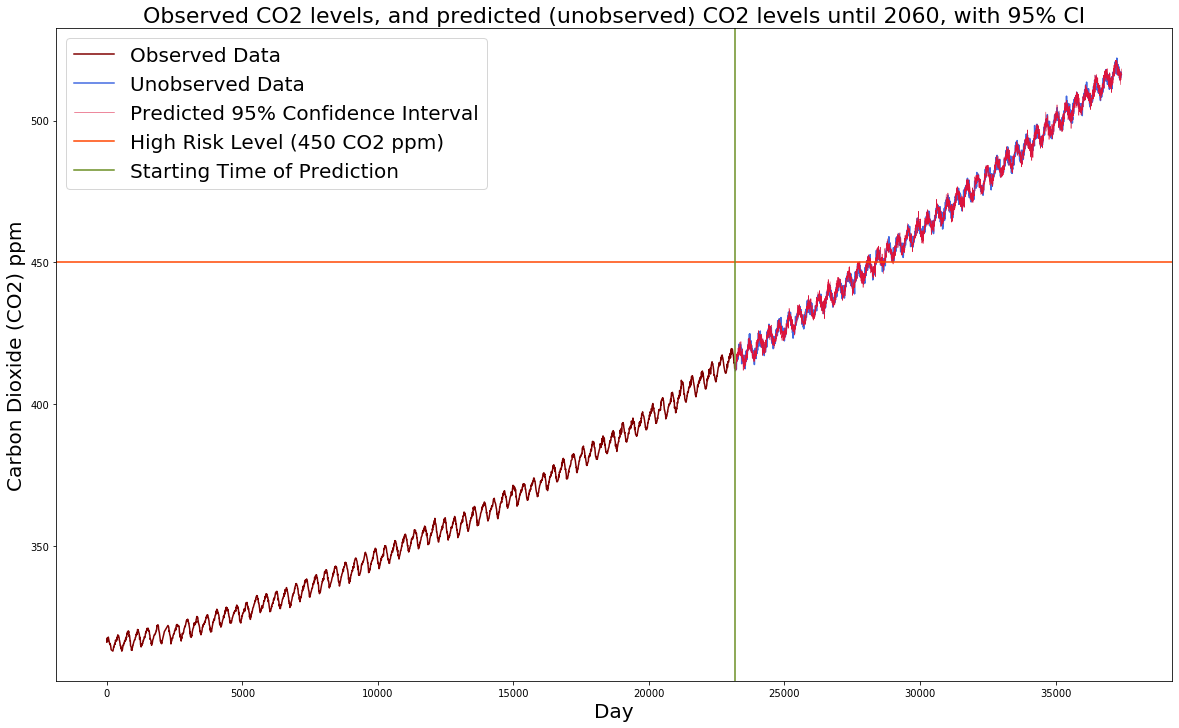

In [499]:
plt.figure(figsize = (20, 12))

# plotting Observed and Unobserved data
plt.plot(data_co2['date_num'], data_co2['co2 ppm'], label = 'Observed Data', color='maroon')
plt.plot(N_future_range, exponential_predicted, color='royalblue', label="Unobserved Data")

# plotting Confidence Intervals
plt.plot(N_future_range, lower_ci, color="crimson", linewidth = 0.5)
plt.plot(N_future_range, upper_ci, color="crimson", linewidth = 0.5, label = "Predicted 95% Confidence Interval")

#plotting a line of the most recent observed CO2 level, from which prediction starts
plt.axhline(450, color='orangered', label = 'High Risk Level (450 CO2 ppm)')
plt.axvline(N_future_range[0], color='olivedrab', label = "Starting Time of Prediction")

plt.xlabel('Day', size = 20)
plt.ylabel('Carbon Dioxide (CO2) ppm', size=20)
plt.legend(prop={'size':20})
plt.title("Observed CO2 levels, and predicted (unobserved) CO2 levels until 2060, with 95% CI", fontsize=22)

plt.show()

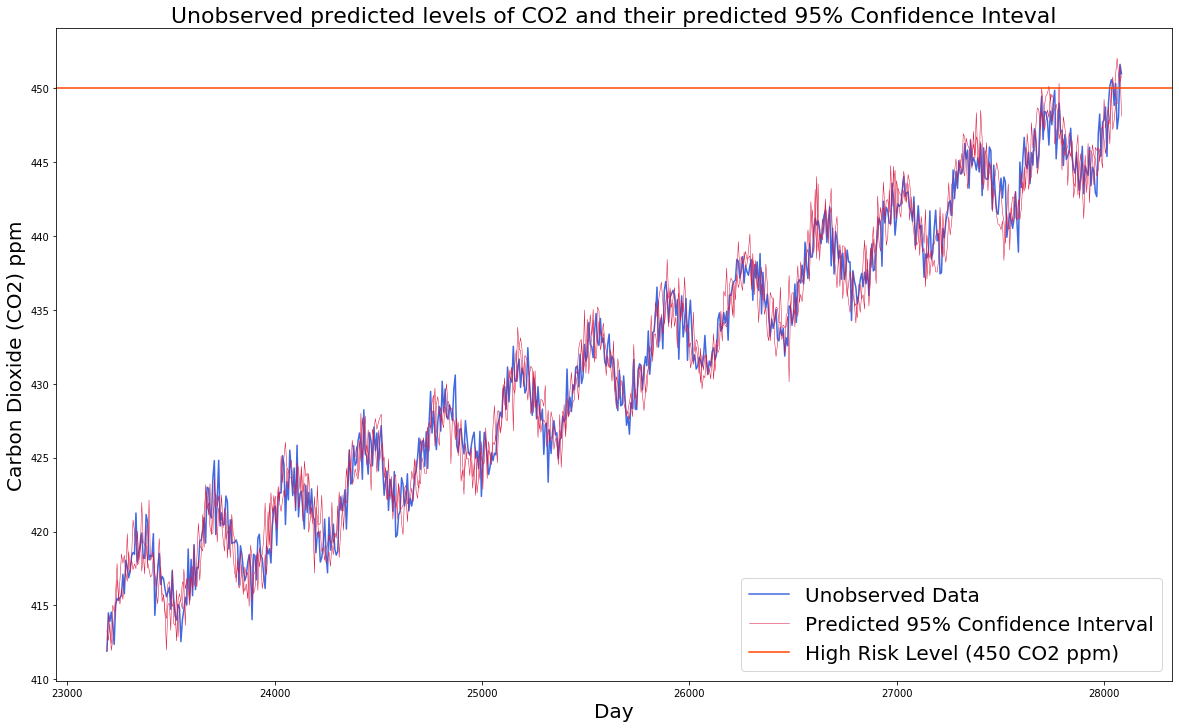

In [500]:
plt.figure(figsize = (20, 12))

# plotting Unobserved (Predicted) data
plt.plot(N_future_range[0:700], exponential_predicted[0:700], color='royalblue', label="Unobserved Data")

# plotting Confidence Intervals
plt.plot(N_future_range[0:700], lower_ci[0:700], color="crimson", linewidth = 0.5)
plt.plot(N_future_range[0:700], upper_ci[0:700], color="crimson", linewidth = 0.5, label = "Predicted 95% Confidence Interval")

#plotting a line of the most recent observed CO2 level, from which prediction starts
plt.axhline(450, color='orangered', label = 'High Risk Level (450 CO2 ppm)')

plt.xlabel('Day', size = 20)
plt.ylabel('Carbon Dioxide (CO2) ppm', size=20)
plt.legend(prop={'size':20})
plt.title('Unobserved predicted levels of CO2 and their predicted 95% Confidence Inteval', fontsize=22)

plt.show()

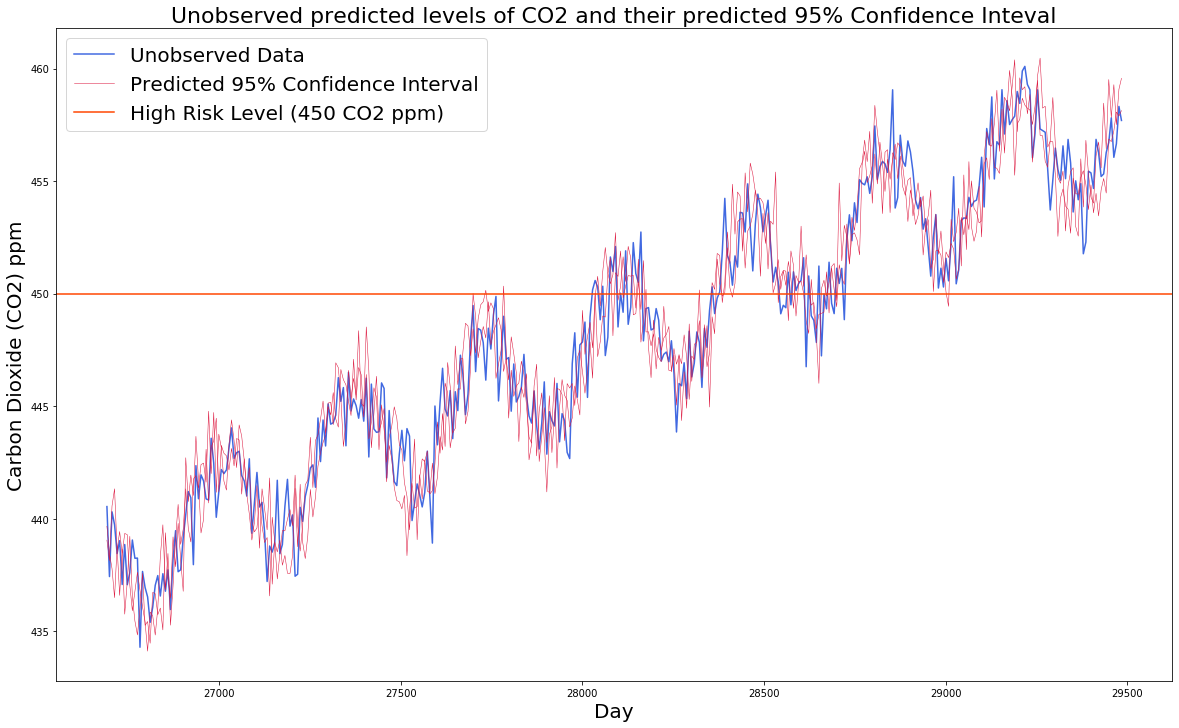

In [501]:
plt.figure(figsize = (20, 12))

# plotting Unobserved (Predicted) data
plt.plot(N_future_range[500:900], exponential_predicted[500:900], color='royalblue', label="Unobserved Data")

# plotting Confidence Intervals
plt.plot(N_future_range[500:900], lower_ci[500:900], color="crimson", linewidth = 0.5)
plt.plot(N_future_range[500:900], upper_ci[500:900], color="crimson", linewidth = 0.5, label = "Predicted 95% Confidence Interval")

#plotting a line of the most recent observed CO2 level, from which prediction starts
plt.axhline(450, color='orangered', label = 'High Risk Level (450 CO2 ppm)')

plt.xlabel('Day', size = 20)
plt.ylabel('Carbon Dioxide (CO2) ppm', size=20)
plt.legend(prop={'size':20})
plt.title('Unobserved predicted levels of CO2 and their predicted 95% Confidence Inteval', fontsize=22)

plt.show()

In [502]:
data_co2_predicted = pd.DataFrame(data={"Day": N_future_range, "mean_co2":exponential_predicted, 'lower_95_ci':lower_ci, 'upper_95_ci': upper_ci})
data_co2_predicted.head()


,Day,mean_co2,lower_95_ci,upper_95_ci
0,23191,411.897884,411.899816,413.310234
1,23198,414.489927,414.411159,412.634425
2,23205,413.900649,413.247219,413.777205
3,23212,414.546644,412.408155,411.946371
4,23219,413.542746,415.007752,412.657745


In [503]:
rng = pd.date_range('2021-09-27', periods=len(data_co2_predicted), freq='W')
data_co2_predicted['date'] = rng
data_co2_predicted

,Day,mean_co2,lower_95_ci,upper_95_ci,date
0,23191,411.897884,411.899816,413.310234,2021-10-03
1,23198,414.489927,414.411159,412.634425,2021-10-10
2,23205,413.900649,413.247219,413.777205,2021-10-17
3,23212,414.546644,412.408155,411.946371,2021-10-24
4,23219,413.542746,415.007752,412.657745,2021-10-31
...,...,...,...,...,...
2030,37401,515.079697,514.677388,512.619967,2060-08-29
2031,37408,516.302986,515.100972,514.599170,2060-09-05
2032,37415,517.111739,514.379520,516.689538,2060-09-12
2033,37422,516.142341,515.457936,516.051466,2060-09-19


In [504]:
high_risk_mean = data_co2_predicted['date'][data_co2_predicted['mean_co2'] >= 450].iloc[0].strftime('%B %d, %Y')
high_risk_lower_ci = data_co2_predicted['date'][data_co2_predicted['lower_95_ci'] >= 450].iloc[0].strftime('%B %d, %Y')
high_risk_upper_ci = data_co2_predicted['date'][data_co2_predicted['upper_95_ci'] >= 450].iloc[0].strftime('%B %d, %Y')

In [505]:
print("Predicted mean of 450 CO2 ppm is to be reached on the date:", high_risk_mean)
print("Predicted lower 95% Confidence Interval of 450 CO2 ppm is to be reached on the date:", high_risk_lower_ci)
print("Predicted upper 95% Confidence Interval of 450 CO2 ppm is to be reached on the date:", high_risk_upper_ci)


Predicted mean of 450 CO2 ppm is to be reached on the date: December 31, 2034
Predicted lower 95% Confidence Interval of 450 CO2 ppm is to be reached on the date: February 05, 2034
Predicted upper 95% Confidence Interval of 450 CO2 ppm is to be reached on the date: March 12, 2034


______

In [31]:
# Create the stan model
stan_code_linear_quadratic_model = """

data {
    // model data
    int<lower=0> N;        //size of the data observations
    real<lower=0> co2[N];  //an observation of CO2 level
    real<lower=0> day[N];  // day of observation collection
}

parameters {
    // model parameters
    real<lower=0> c0;   // intercept parameter
    real<lower=0> c1;   // slope value parameter
    real<lower=0> c2; // seasonal variation parameter (multiplicator)
    real<lower=0> c3;  // additional time trend parameter 
    real<lower=0, upper=1> c4; // day variation parameter (added to annual number of days) 
    real<lower=0> sigma;        // standard deviation for noise parameter         
}


model {
    //priors 
    c0 ~ normal(300, 15); // prior based on the values of CO2 level at the start
    c1 ~ cauchy(0, 1); // slope (time) parameter prior
    c2 ~ cauchy(0, 1); // slope (seasonal variation) parameter prior
    c3 ~ cauchy(0, 1); // day (seasonal variation) parameter prior
    c4 ~ cauchy(0, 1); // time trend parameter for quadratic expression
    sigma ~ cauchy(0, 1); // prior for standard deviation^2 (variance)

    //likelihood
    for (observation in 1:N) {
      co2[observation] ~ normal(c0+c1*day[observation]+c2*day[observation]^2+c3*cos(2*pi()*day[observation]/(365.25+c4)), sigma);
    }

}
"""

In [32]:
#compile the model
stan_model_linear_quadratic= pystan.StanModel(model_code=stan_code_linear_quadratic_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c58e062041b192fd047f21adad4dcf99 NOW.


CompileError: command 'x86_64-apple-darwin13.4.0-clang' terminated by signal 6

In [18]:
# Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.
stan_results_exponential = stan_model_exponential.sampling(data=stan_data)
print(stan_results_exponential)

RuntimeError: Initialization failed.

In [ ]:
# Extract the generated samples from the stan model
samples_exponential = stan_results_exponential.extract()

In [ ]:
parameters_exponential = ['c0', 'c1', 'c2', 'c3', 'sigma']
acf_plots(samples_exponential, parameters_exponential)

In [ ]:
pair_plots(samples_exponential, parameters_exponential)

In [ ]:
exponential_model_co2 = np.array(sts.norm.rvs(np.mean(samples_exponential['c0'])+ exp(np.mean(samples_exponential['c1'])*(data_co2.iloc[:,3]))+np.mean(samples_exponential['c2'])*np.cos((2*np.pi*data_co2.iloc[:,3])/365.25+np.mean(samples_exponential['c3'])), np.mean(samples_exponential['sigma'])))
plt.plot(data_co2.iloc[:,3], exponential_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.show()

In [ ]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], exponential_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([17000, 18000, 360, 395])
plt.show()

In [ ]:
## zooming in on the original plot
plt.plot(data_co2.iloc[:,3], exponential_model_co2, color='royalblue')
plt.plot(data_co2.iloc[:,3], data_co2.iloc[:,1], color='maroon')
plt.axis([22000, 23000, 400, 430])
plt.show()